In [ ]:
#@title Notebook pre steps

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection (or line): Cmd+Shift+Enter

# install missing packages
!pip install scikit-misc
import pandas as pd
from IPython.display import display
import random
import sys
from pprint import pprint as pp

# RL in action (Tic-Tac-Toe)

Tic-Tac-Toe is a simple two-player game where players alternately place their marks on a 3x3 grid. That is, the current state of the board is the players' marks on the grid. The first player to align three of their marks horizontally, vertically, or diagonally wins the game.  Reward for a player is 1 for 'win', 0.5 for 'draw', and 0 for 'loss'. These values can be seen as the probability of winning.


This notebook uses reinforcement learning to teach an agent optimal strategies through play with another agent.

## Setting up the environment

First we define the environment class for the game.

In [ ]:
#@title Environment (code)

class EnvTicTacToe:
    """
    Class representing the Tic-Tac-Toe game environment. The state is
    represented using a list of 9 strings with the players mark or ' ' for empty.
    The 3x3 grid is read from right to left and down.
    """
    def __init__(self):
        """
        Initializes an empty Tic-Tac-Toe board.
        """
        self.board = [' '] * 9  # a list with 9 ' ' strings (empty state)

    def reset(self):
        """
        Resets the board to an empty state, clearing all marks.
        """
        self.board = [' '] * 9  # resets self.board to a list of 9 ' ' strings.

    def is_winner_cur_state(self, mark):
        """
        Checks if the player with the given mark has won the game.

        Args:
            mark (str): The mark of the player to check (e.g 'X' or 'O').
        Returns:
            bool: True if the player has won, False otherwise.
        """
        wins = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]  # wins is a list of tuples of integers
        return any(all(self.board[i] == mark for i in win) for win in wins)

    def is_winner_state(self, state, mark):
        """
        Checks if the player with the given mark has won the game in a given state.

        Args:
            mark (str): The mark of the player to check (e.g 'X' or 'O').
        Returns:
            bool: True if the player has won, False otherwise.
        """
        wins = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]  # wins is a list of tuples of integers
        return any(all(state[i] == mark for i in win) for win in wins)

    def available_moves(self):
        """
        Returns a list of available moves (indices of empty positions) on the board.

        Returns:
            list: A list of integers representing the available move positions.
        """
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def make_move(self, position, mark):
        """
        Places the specified mark on the board at the given position.

        Args:
            position (int): The index (0-8) on the board to place the mark.
            mark (str): The mark to place (e.g. 'X' or 'O').
        """
        self.board[position] = mark

    def is_full_cur_state(self):
        """
        Checks if the board is full (no empty spaces).

        Returns:
            bool: True if the board is full, False otherwise.
        """
        return ' ' not in self.board

    def is_full_state(self, state):
      return ' ' not in state

    def current_state(self):
        """
        Returns the current state of the board as a tuple.

        Returns:
            tuple: A tuple representing the current state of the board.
        """
        # Returns the current state of the board as a tuple
        return tuple(self.board)  # Returns a tuple of strings.

    def print_board(self):
        """
        Prints the Tic-Tac-Toe board in a formatted text representation.
        """
        for i in range(0, 9, 3):
            print('|'.join(self.board[i:i+3]))
            if i < 6:
                print('-----')

    def print_board_table(self):
            """
            Prints the Tic-Tac-Toe board as a formatted table in the Jupyter notebook output.

            This method uses the pandas library to create a DataFrame representation of the board,
            applies CSS styling to make it visually resemble a grid, and then uses
            IPython.display.display to render the table in the notebook output.
            """
            s = self.board
            tbl = pd.DataFrame([s[i:i + 3] for i in range(0, 9, 3)])
            styles = [
                {'selector': 'table, th, td', 'props': [('border', '1px solid black'), ('border-collapse', 'collapse'), ('padding', '5px')]},
                {'selector': 'td', 'props': [('height', '20px'), ('width', '20px'), ('text-align', 'center'), ('vertical-align', 'middle')]}
            ]
            display(tbl.style.set_table_styles(styles).hide(axis="index").hide(axis="columns"))

Let us test the class.

In [ ]:
#@title Testing game environment (code)

game = EnvTicTacToe() # Create an instance of the Tic-Tac-Toe environment
game.make_move(2, 'X') # Make a move for player 'X' at position 2 (top-right)
game.make_move(8, 'O') # Make a move for player 'O' at position 8 (bottom-right)
print("After one round:") # Print a message indicating the board state after one round
game.print_board_table() # Print the current state of the board as a formatted table

game.board = [' ', ' ', 'X', ' ', 'X', ' ', 'X', 'O', 'O'] # Set the board to a specific state where Player X wins
print("\nPlayer X wins:", game.is_winner_cur_state('X')) # Check if Player X is the winner in this state and print the result
game.print_board_table() # Print the board state where Player X wins

print("\nPlayer X loose:") # Print a message indicating a state where Player X loses
game.board = ['X', ' ', 'X', ' ', 'X', ' ', 'O', 'O', 'O'] # Set the board to a specific state where Player O wins (Player X loses)
game.print_board_table() # Print the board state where Player X loses

print("\nA draw:") # Print a message indicating a draw state
game.board = ['X', 'X', 'O', 'O', 'O', 'X', 'X', 'X', 'O'] # Set the board to a specific state representing a draw
game.print_board_table() # Print the board state that is a draw

After one round:


,,X
,,
,,O



Player X wins: True


,,X
,X,
X,O,O



Player X loose:


X,,X
,X,
O,O,O



A draw:


X,X,O
O,O,X
X,X,O


## Players (agents) and learning to play


Assume that we initially define a value $V(S)$ of each state $S$ to be 1 if we win, 0 if we loose and 0.5 otherwise.

Let us first define a RL agent that learns based on a value function. Most of the time we *exploit* our knowledge, i.e. choose the action which gives us the highest estimated reward (probability of winning). However, some times (with probability $\epsilon$) we *explore* and choose another action/move than what seems optimal. These moves make us experience states we may otherwise never see. If we exploit we update the value of a state using $$V(S_t) = V(S_t) + \alpha(V(S_{t+1})-V(S_t))$$ where $\alpha$ is the *step-size* parameter which influences the rate of learning.

The method `do_action` takes the current state (from our point of view) and the next state (after moveing) and update the value function (if exploit). The player explore with probability $\epsilon$ if there is not a next state that makes us win.

In [ ]:
#@title RL agent (code)

class RLAgent:
    """
    Class representing an RL agent using an epsilon-greedy policy. The value
    function is stored in a dictionary using lazy initialization, i.e. we only
    add the value of a state when it is encountered for the first time.
    """

    def __init__(self, mark, alpha=0.1, epsilon=0.1):
        """
        Initializes a new RL Agent.

        Args:
            mark (str): The agent's mark on the board (e.g. 'X' or 'O'). Defaults to 'X'.
            alpha (float): The learning rate for value updates. Defaults to 0.1.
            epsilon (float): The exploration rate for the epsilon-greedy policy. Defaults to 0.1.
        """
        self.mark = mark  # Agent's mark
        self.V = {}  # State-value directory (currently empty)
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration rate
        self.curstate =  (' ') * 9  # Current state of the game

    def new_game(self):
      """
      Reset the current state of the game.
      """
      self.curstate =  (' ') * 9  # Current state of the game

    def reset_learning(self):
      """
      Reset the learning parameters.
      """
      self.V = {}  # State-value directory (currently empty)

    def get_value(self, state, game):
        """
        Get value for a given board state.

        If the state has not been seen before, it is initialized with a value 1 if win, 0 if draw else 0.5.

        Args:
            state (tuple): A tuple representing the current state of the board.
            game (EnvTicTacToe): The game environment object.

        Returns:
            float: The estimated value of the state.
        """
        # Retrieves value for a state, initializing if unseen
        if state not in self.V:
          if game.is_winner_state(state, self.mark):
            self.V[state] = 1
          elif game.is_full_state(state):
            self.V[state] = 0
          else:
            self.V[state] = 0.5

        return self.V[state]

    def do_action(self, game, verbose=False):
        """
        Chooses the next action (move) for the agent based on an epsilon-greedy policy.
        Moreover, if exploit the value of the current state (before action) is updated.

        With probability epsilon, the agent chooses a random available move (exploration).
        Otherwise (1 - epsilon probability), the agent chooses the move that leads
        to the state with the maximum value (for 'X') or minimum value (for 'O')
        among the available moves (exploitation).

        Args:
            game (EnvTicTacToe): The current game environment object.
            verbose (bool): If True, prints the board state after each move.
                            Defaults to False.

        Returns:
            int: The index of the chosen move (position on the board).
        """
        if verbose: print(f'\nStart finding player {self.mark} action:')
        # find values of possible moves
        available = game.available_moves()  # list of indices
        if verbose: print(f'Available {available}')
        values = [] # list with possible moves, i.e. tuples with (value, move idx). Now empty
        for move in available: # for each possible move (index)
            game.make_move(move, self.mark) # do the move
            values.append((self.get_value(game.current_state(), game), move)) # store the value of the move in tuple (value, move idx)
            game.make_move(move, ' ') # reset the board state to previous
        maxval = max(values)[0]
        if verbose: print(f'Values {values}')

        # Explore
        if random.random() < self.epsilon and maxval < 1 and any(v[0] < maxval for v in values) :  # explore if less than eps, we cannot win in a move and we don't have all values equal
            if verbose: print('Explore')
            indices = [i for v, i in values if v < maxval]  # find an index among non optimal states
            idx = random.choice(indices) # choose a random move among non optimal states
            game.make_move(idx, self.mark) # do the move
            self.curstate = game.current_state() # store the now current state
            return idx

        # Else exploit
        indices = [i for v, i in values if v == maxval]  # index that are optimal
        idx = random.choice(indices) # choose a random move among non optimal states
        if verbose: print(f'Exploit {idx}')
        if self.curstate not in self.V:
            self.V[self.curstate] = self.get_value(self.curstate, game)
        if verbose: print(f'Update {self.curstate} from {self.V[self.curstate]} ', end="")
        self.V[self.curstate] += self.alpha * (maxval - self.V[self.curstate])
        if verbose: print(f'to {self.V[self.curstate]}')
        game.make_move(idx, self.mark) # do the move
        self.curstate = game.current_state() # store the now current state
        return idx

Other players may be defined similarly, e.g. a player which moves randomly (if can not win in the next move):

In [ ]:
#@title Random action agent (code)

import random

class RandomActionAgent:
    """
    Class representing an agent which moves randomly (if can not win in the next move).
    """

    def __init__(self, mark):
        """
        Initializes a new RandomActionAgent.

        Args:
            mark (str): The agent's mark on the board (e.g. 'X' or 'O').
        """
        self.mark = mark  # Agent's mark ('X' or 'O')

    def new_game(self):
      """
      Reset the current state of the game.
      """

    def reset_learning(self):
      """
      Reset the learning parameters.
      """

    def do_action(self, game, verbose=False):
        """
        Chooses the next action (move) for the agent.

        The agent first checks if any available move leads to an immediate win.
        If a winning move exists, it makes that move. Otherwise, it chooses
        a random available move.

        Args:
            game (EnvTicTacToe): The current game environment object.

        Returns:
            int: The index (0-8) of the chosen move (position on the board).
        """
        if verbose: print(f'\nStart finding player {self.mark} action:')
        available = game.available_moves()  # Get a list of indices of empty positions
        win = False # Flag to indicate if a winning move was found
        idx = -1 # Variable to store the index of the winning move

        for move in available: # Iterate through each available move
            game.make_move(move, self.mark) # Temporarily make the move on the game board
            win = game.is_winner_cur_state(self.mark) # Check if this temporary move results in a win
            game.make_move(move, ' ') # Undo the temporary move to restore the board state
            if win:
              idx = move # Store the index of the winning move
              break  # Exit the loop since a winning move is found

        if win:  # If a winning move was found
          if verbose: print('Win')
          game.make_move(idx, self.mark) # Make the winning move on the actual board
          return idx # Return the index of the winning move

        # Else pick random
        idx = random.choice(available)  # If no winning move, choose a random move from available moves
        game.make_move(idx, self.mark) # Make the random move on the actual board
        if verbose: print(f'Pick random action {idx}')
        return idx # Return the index of the random move

A player which always place at the lowest field index:

In [ ]:
#@title First free index agent

class FirstIndexAgent:
    """
    Class representing an agent which moves to the first free index (if can not win in the next move).

    This agent's strategy is to check if any available move leads to an immediate win.
    If a winning move is found, it makes that move. Otherwise, it selects
    the move corresponding to the lowest available index on the board.
    """

    def __init__(self, mark):
        """
        Initializes a new FirstIndexAgent.

        Args:
            mark (str): The agent's mark on the board (e.g. 'X' or 'O').
        """
        self.mark = mark  # Agent's mark ('X' or 'O')

    def new_game(self):
      """
      Reset the current state of the game.
      """

    def reset_learning(self):
      """
      Reset the learning parameters.
      """

    def do_action(self, game, verbose=False):
        """
        Chooses and executes the next action (move) for the agent.

        The agent first iterates through all available moves to check if making any
        of them would result in an immediate win. This check is done temporarily
        on the game board.

        If a winning move is found, the agent makes that move permanently.
        If no winning move is found, the agent makes a move to the position
        with the lowest index among the available moves.

        Args:
            game (EnvTicTacToe): The current game environment object.

        Returns:
            int: The index (0-8) of the chosen move (position on the board).
        """
        if verbose: print(f'\nStart finding player {self.mark} action:')
        # Find available moves (indices of empty positions)
        available = game.available_moves()
        win = False  # Flag to indicate if a winning move was found
        idx = -1  # Variable to store the index of the winning move

        # Check if any available move leads to a win
        for move in available:
            game.make_move(move, self.mark)  # Temporarily make the move to check the outcome
            win = game.is_winner_cur_state(self.mark)  # Check if this temporary move results in a win for this agent
            game.make_move(move, ' ')  # Undo the temporary move to restore the board state for the next check
            if win:
              idx = move  # If a winning move is found, store its index and stop checking
              break

        # If a winning move was found during the check
        if win:
          if verbose: print('Win')
          game.make_move(idx, self.mark)  # Make the winning move permanently on the actual board
          return idx  # Return the index of the winning move

        # If no winning move was found, pick the move with the first available index
        if verbose: print(f'Pick first free index {available[0]}')
        game.make_move(available[0], self.mark)  # Make the move on the actual board at the lowest available index
        return available[0]  # Return the index of the move (the first available index)

## Gameplay

We define a game which returns the prefix of the winner (`Draw` if a draw):

In [ ]:
#@title Play a game (code)

def play_game(player1, player2, game, verbose = False):
    """
    Plays a single game of Tic-Tac-Toe between two players. The play start
    with a random player.

    The game proceeds turn by turn, with each player choosing an action
    until a win or a draw occurs.

    Args:
        player1: The first player object (should have a do_action method
                 and a mark attribute).
        player2: The second player object (should have a do_action method
                 and a mark attribute).
        game: The game environment object.
        verbose (bool): If True, prints the board state after each move.
                        Defaults to False.

    Returns:
        dict: A dictionary containing:
              - 'winner' (str): The mark of the winning player (e.g. 'X' or 'O'),
                or 'Draw' if the game ends in a draw.
              - 'first' (str): The mark of the player who started the game.
    """
    game.reset()
    player1.new_game()
    player2.new_game()

    # Choose who to start randomly
    if random.random() <= 0.5:
      current_player = player1
      first_player = player1
      next_player = player2
    else:
      current_player = player2
      first_player = player2
      next_player = player1

    while True:
      current_player.do_action(game, verbose)  # do action

      if verbose:
        print(f'Player {current_player.mark}:')
        game.print_board_table()

      if game.is_winner_cur_state(current_player.mark):
        if verbose: print(f'Player {current_player.mark} wins!')
        return {'winner': current_player.mark, 'first': first_player.mark}

      if game.is_full_cur_state():
        if verbose: print('Draw!')
        return {'winner': 'Draw', 'first': first_player.mark}

      # Switch player
      if current_player.mark == first_player.mark:
        current_player = next_player
      else:
        current_player = first_player


# Define players and play a game
random.seed(22)  # set seed so get same results
game = EnvTicTacToe()
player1 = RLAgent(mark='RL')
player2 = RandomActionAgent(mark='R')
play_game(player1, player2, game, verbose=True)


Start finding player R action:
Pick random action 2
Player R:


,,R
,,
,,



Start finding player RL action:
Available [0, 1, 3, 4, 5, 6, 7, 8]
Values [(0.5, 0), (0.5, 1), (0.5, 3), (0.5, 4), (0.5, 5), (0.5, 6), (0.5, 7), (0.5, 8)]
Exploit 8
Update           from 0.5 to 0.5
Player RL:


,,R
,,
,,RL



Start finding player R action:
Pick random action 1
Player R:


,R,R
,,
,,RL



Start finding player RL action:
Available [0, 3, 4, 5, 6, 7]
Values [(0.5, 0), (0.5, 3), (0.5, 4), (0.5, 5), (0.5, 6), (0.5, 7)]
Exploit 7
Update (' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', 'RL') from 0.5 to 0.5
Player RL:


,R,R
,,
,RL,RL



Start finding player R action:
Win
Player R:


R,R,R
,,
,RL,RL


Player R wins!


{'winner': 'R', 'first': 'R'}

### Your turn

Have look at the value function for player 1 (RL player)

  1) Have some of the values been updated? If not, try to play again until player 1 wins.


In [ ]:
#@title Add your code



In [ ]:
#@title Solution

print("Old values:")
pp(player1.V)
play_game(player1, player2, game, verbose=True)
print("Updated values")
pp(player1.V)

## We first start updating when V(S_t+1)-V(S_t) not 0

Old values:
{'         ': 0.5,
 (' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', 'RL'): 0.5,
 (' ', ' ', 'R', ' ', ' ', ' ', ' ', 'RL', ' '): 0.5,
 (' ', ' ', 'R', ' ', ' ', ' ', 'RL', ' ', ' '): 0.5,
 (' ', ' ', 'R', ' ', ' ', 'RL', ' ', ' ', ' '): 0.5,
 (' ', ' ', 'R', ' ', 'RL', ' ', ' ', ' ', ' '): 0.5,
 (' ', ' ', 'R', 'RL', ' ', ' ', ' ', ' ', ' '): 0.5,
 (' ', 'R', 'R', ' ', ' ', ' ', ' ', 'RL', 'RL'): 0.5,
 (' ', 'R', 'R', ' ', ' ', ' ', 'RL', ' ', 'RL'): 0.5,
 (' ', 'R', 'R', ' ', ' ', 'RL', ' ', ' ', 'RL'): 0.5,
 (' ', 'R', 'R', ' ', 'RL', ' ', ' ', ' ', 'RL'): 0.5,
 (' ', 'R', 'R', 'RL', ' ', ' ', ' ', ' ', 'RL'): 0.5,
 (' ', 'RL', 'R', ' ', ' ', ' ', ' ', ' ', ' '): 0.5,
 ('RL', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' '): 0.5,
 ('RL', 'R', 'R', ' ', ' ', ' ', ' ', ' ', 'RL'): 0.5}

Start finding player R action:
Pick random action 5
Player R:


,,
,,R
,,



Start finding player RL action:
Available [0, 1, 2, 3, 4, 6, 7, 8]
Values [(0.5, 0), (0.5, 1), (0.5, 2), (0.5, 3), (0.5, 4), (0.5, 6), (0.5, 7), (0.5, 8)]
Exploit 1
Update           from 0.5 to 0.5
Player RL:


,RL,
,,R
,,



Start finding player R action:
Pick random action 2
Player R:


,RL,R
,,R
,,



Start finding player RL action:
Available [0, 3, 4, 6, 7, 8]
Values [(0.5, 0), (0.5, 3), (0.5, 4), (0.5, 6), (0.5, 7), (0.5, 8)]
Exploit 0
Update (' ', 'RL', ' ', ' ', ' ', 'R', ' ', ' ', ' ') from 0.5 to 0.5
Player RL:


RL,RL,R
,,R
,,



Start finding player R action:
Win
Player R:


RL,RL,R
,,R
,,R


Player R wins!
Updated values
{'         ': 0.5,
 (' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'RL'): 0.5,
 (' ', ' ', ' ', ' ', ' ', 'R', ' ', 'RL', ' '): 0.5,
 (' ', ' ', ' ', ' ', ' ', 'R', 'RL', ' ', ' '): 0.5,
 (' ', ' ', ' ', ' ', 'RL', 'R', ' ', ' ', ' '): 0.5,
 (' ', ' ', ' ', 'RL', ' ', 'R', ' ', ' ', ' '): 0.5,
 (' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', 'RL'): 0.5,
 (' ', ' ', 'R', ' ', ' ', ' ', ' ', 'RL', ' '): 0.5,
 (' ', ' ', 'R', ' ', ' ', ' ', 'RL', ' ', ' '): 0.5,
 (' ', ' ', 'R', ' ', ' ', 'RL', ' ', ' ', ' '): 0.5,
 (' ', ' ', 'R', ' ', 'RL', ' ', ' ', ' ', ' '): 0.5,
 (' ', ' ', 'R', 'RL', ' ', ' ', ' ', ' ', ' '): 0.5,
 (' ', ' ', 'RL', ' ', ' ', 'R', ' ', ' ', ' '): 0.5,
 (' ', 'R', 'R', ' ', ' ', ' ', ' ', 'RL', 'RL'): 0.5,
 (' ', 'R', 'R', ' ', ' ', ' ', 'RL', ' ', 'RL'): 0.5,
 (' ', 'R', 'R', ' ', ' ', 'RL', ' ', ' ', 'RL'): 0.5,
 (' ', 'R', 'R', ' ', 'RL', ' ', ' ', ' ', 'RL'): 0.5,
 (' ', 'R', 'R', 'RL', ' ', ' ', ' ', ' ', 'RL'): 0.5,
 (' ', 'RL', ' ', ' ', ' ', 

## Learning by a sequence of runs

With a single game only a few states are explored and estimates are not good. Let us instead play a sequence of games and learn along the way:

In [ ]:
#@title Play a set of games (code)

import random
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_smooth, labs, theme, element_text, theme_minimal
from math import ceil
from skmisc.loess import loess as loess_klass

def play_games(runs, player1, player2, game, verbose=False, keep_first_periods = False):
    """
    Simulate a series of Tic-Tac-Toe games between two players and analyze the results.

    This function plays a specified number of games, records the outcome of each
    game (winner and who went first), calculates the win rate for player1, and
    generates a plot showing the win rate over time.

    Args:
        runs (int): The number of games to simulate.
        player1 (object): The first player object. Must have a 'mark' attribute
                         and a 'new_game' method. If it's an RL agent, it will
                         update its value function during play.
        player2 (objetc.): The second player object. Must have a 'mark' attribute
                         and a 'new_game' method.
        game (EnvTicTacToe): The game environment object (an instance of EnvTicTacToe).
                             This object's state will be modified during the games.
        verbose (bool): If True, prints details of each game turn by turn.
                        Defaults to False.
        keep_first_periods (bool): If True then do rolling horizon plot over the first periods too.
                                   Defaults to False.

    Returns:
        dict: A dictionary containing:
              - 'dat' (pd.DataFrame): A DataFrame with the results of each game,
                including the game number, winner, first player, player1's win
                outcome (1 for win, 0 for loss, 0.5 for draw), and a rolling
                average of player1's win outcome.
              - 'plot' (plotnine.ggplot.ggplot): A plotnine plot object visualizing
                player1's rolling average win rate over the games, with a LOESS
                trend line.
    """
    win_seq = []
    first_seq = []

    for _ in range(runs):
        res = play_game(player1, player2, game, verbose)

        win_seq.append(res['winner'])
        first_seq.append(res['first'])

    # Process results
    df = pd.DataFrame({
        'game': range(1, runs + 1),
        'winner': win_seq,
        'first': first_seq
    })

    df['winA'] = df['winner'].apply(
        lambda w: 1 if w == player1.mark else (0 if w == player2.mark else 0.5)
    )

    roll_window = ceil(runs / 10)
    if keep_first_periods:
      mp = 1
    else:
      mp = roll_window
    df['winsA_r'] = df['winA'].rolling(window=roll_window, min_periods=mp).mean()

    # Create plot
    pt = (
        ggplot(df.iloc[roll_window:], aes(x='game', y='winA')) +
        geom_line(aes(y='winsA_r'), size=0.2) +
        geom_smooth(method='loess', span=0.9, se=False, color='blue', size=0.3) +
        labs(
            y=f"Avg. wins player {player1.mark}",
            x = "Games",
            title=f"Wins {player1.mark} = {df['winA'].mean():.2f}"
        ) +
        theme(figure_size=(10, 6))
    )
    return {"dat": df, "plot": pt, "means": f"{player1.mark} = {df['winA'].mean():.2f}, {player2.mark} = {1 - df['winA'].mean():.2f}"}

Let us now play games against a player who moves randomly using $\epsilon = 0.1$ (explore probability) and $\alpha = 0.1$ (step size).

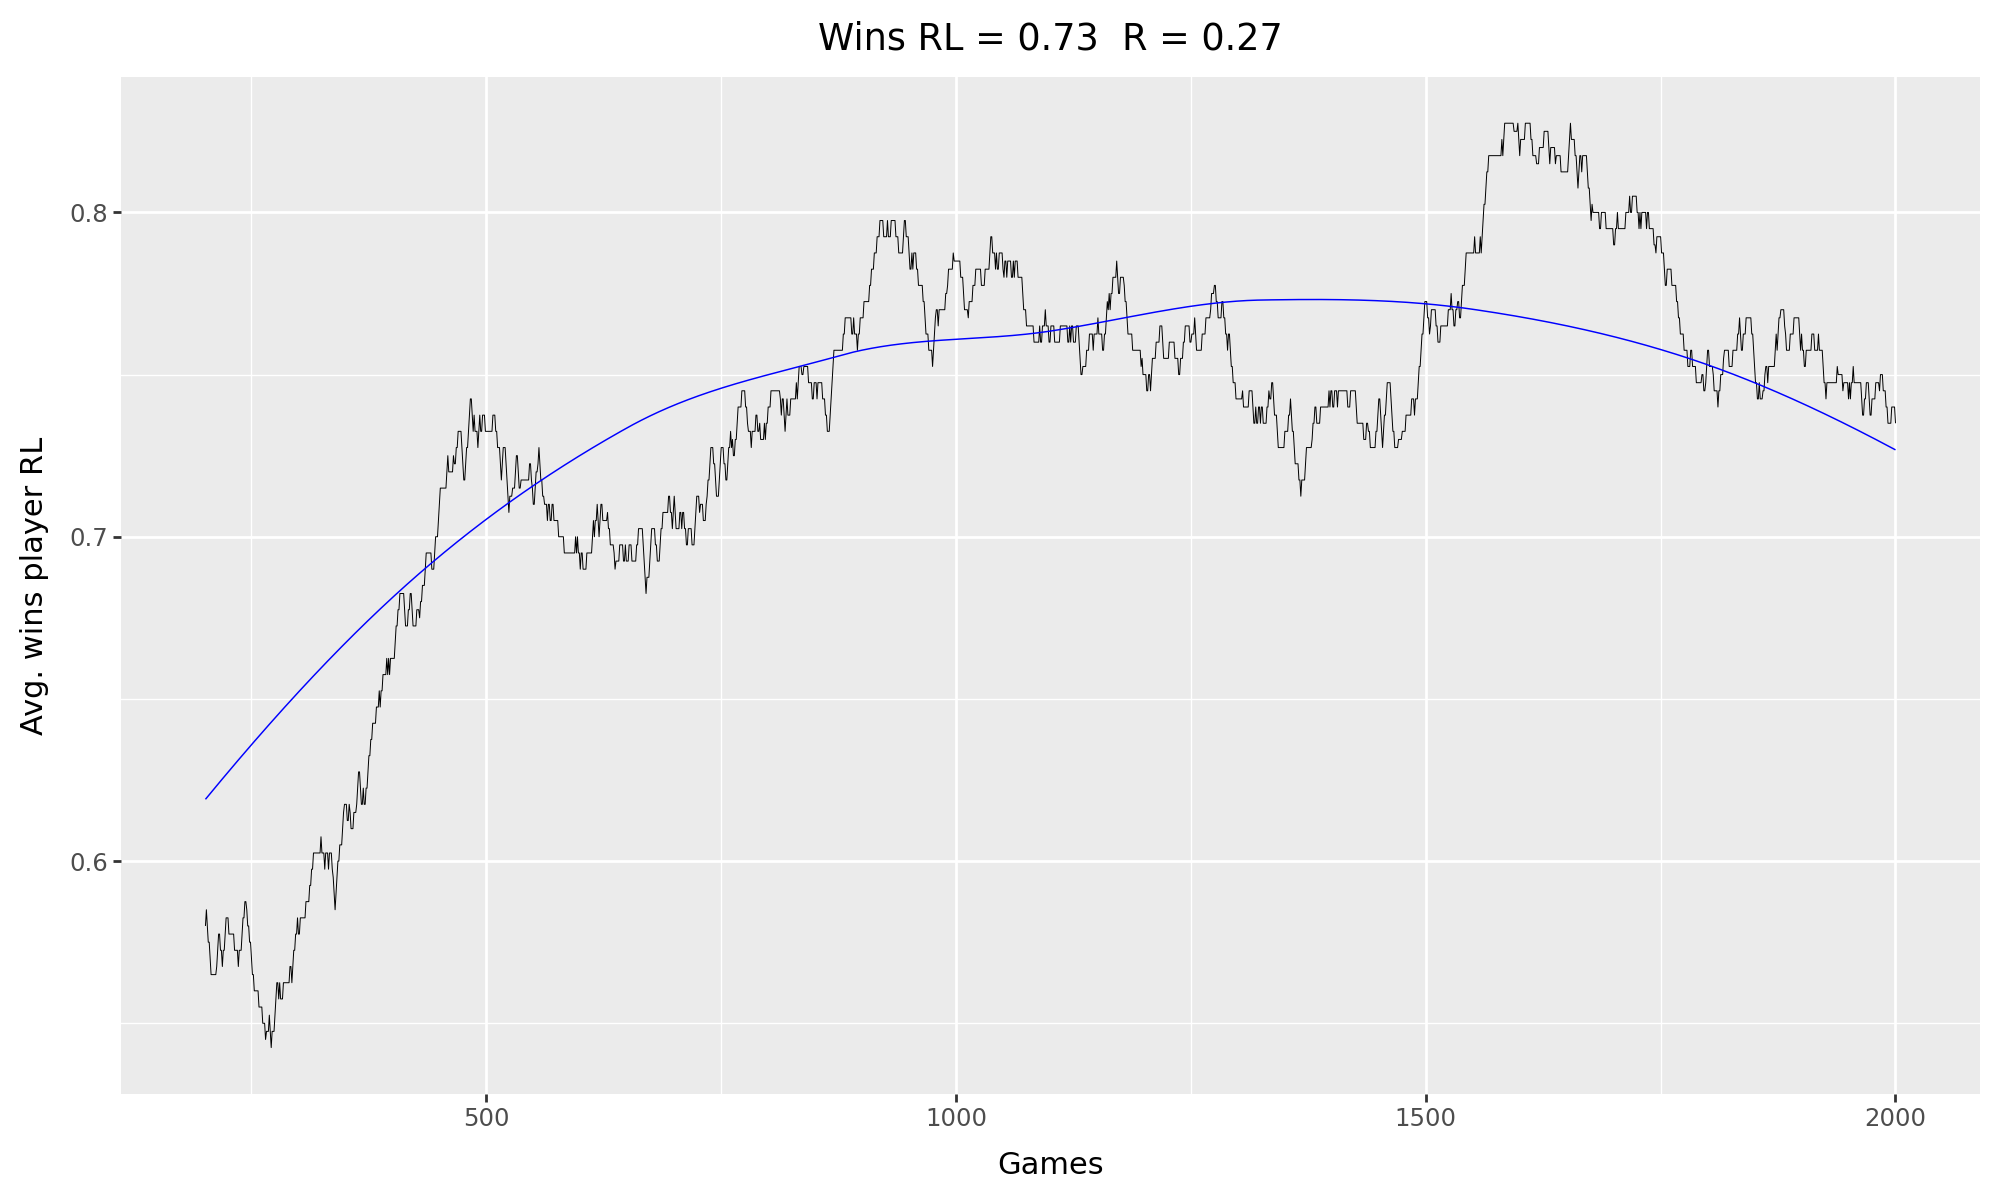

,game,winner,first,winA,winsA_r
0,1,R,R,0.0,NaN
1,2,R,R,0.0,NaN
2,3,RL,RL,1.0,NaN
3,4,RL,R,1.0,NaN
4,5,RL,RL,1.0,NaN
...,...,...,...,...,...
1995,1996,RL,RL,1.0,0.740
1996,1997,RL,RL,1.0,0.740
1997,1998,RL,RL,1.0,0.740
1998,1999,RL,R,1.0,0.740


In [ ]:
random.seed(52)  # set seed so get same results
game = EnvTicTacToe()
playerRL = RLAgent(mark='RL')
playerR = RandomActionAgent(mark='R')
res = play_games(2000, playerRL, playerR, game)
res['plot'].show()
res['dat']

The black curve is the moving average of winning with a blue trend line.

### Your turn

Comment on the output

  1. Is the RL player winning always?

    <details>
    <summary>Solution</summary>
    No, but as it learns, it wins more often (on average 73% of the time).
    </details>

  2. Is the RL player learning?

    <details>
    <summary>Solution</summary>
    Yes, as seen, the rolling horizon goes up. However, exploitation may lower our win rate, too.
    </details>


## Effect of learning parameters

Note the values of the parameters have an effect on our learning. Let us use different exploration rate and step-size.

/usr/local/lib/python3.12/dist-packages/plotnine/scales/scale_alpha.py:71: PlotnineWarning: Using alpha for a discrete variable is not advised.


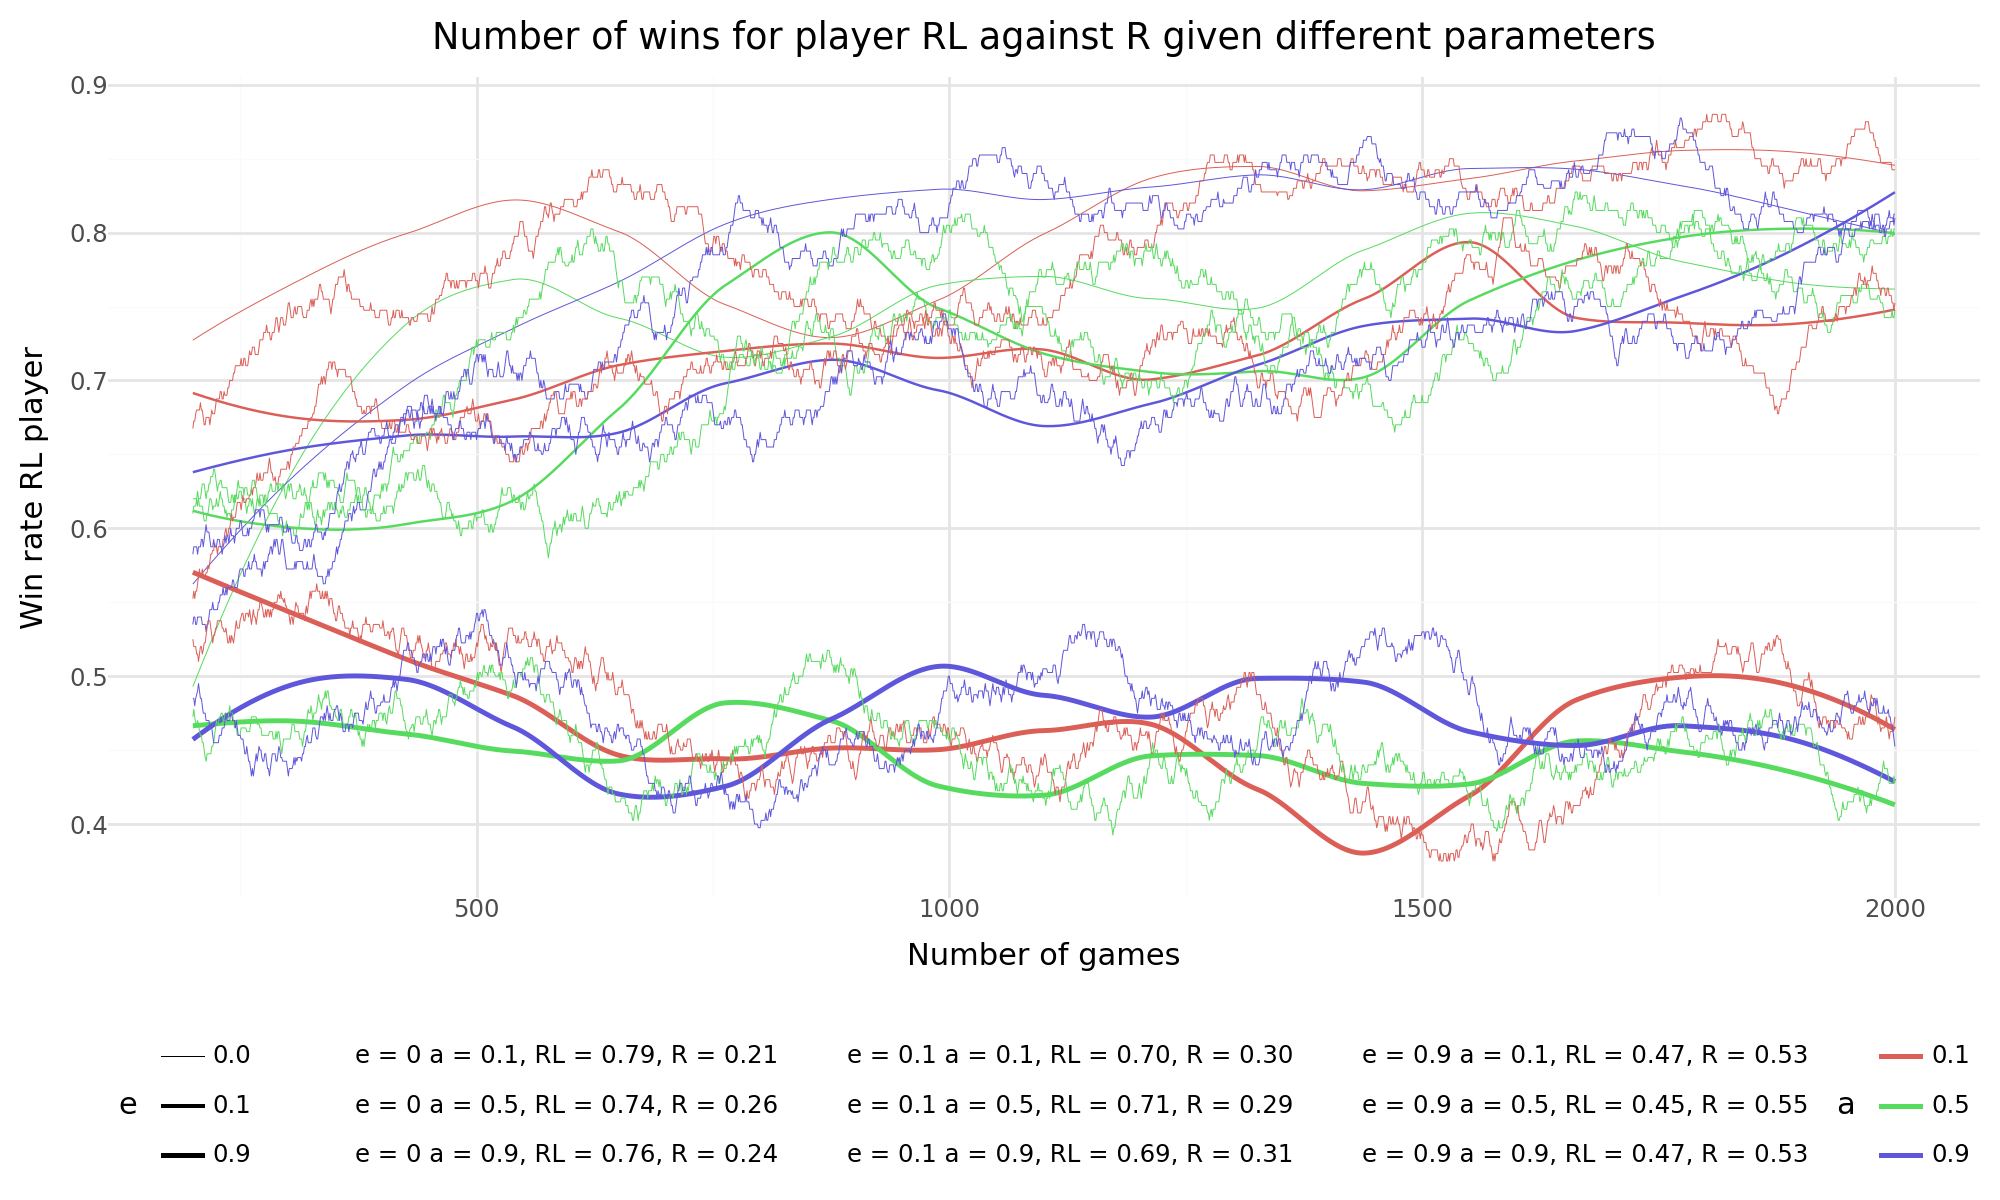

In [ ]:
#@title Effect of control parameters (against random choice player)

import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_smooth, geom_point, labs, theme, element_text, theme_minimal, guides, scale_size_manual
from plotnine.guides import guide_legend # Import guide_legend
import random
from skmisc.loess import loess as loess_klass

def plot_param_effects(control_list, runs, player2, game):
    """
    Simulates games for different RL agent parameter configurations and plots
    the win rate against a given opponent.

    Args:
        control_list (list): A list of dictionaries, where each dictionary
                             contains 'epsilon' and 'alpha' values for an RL agent.
        runs (int): The number of games to simulate for each parameter configuration.
        player2 (object): The second player object (the opponent).
        game (EnvTicTacToe): The game environment object.

    Returns:
        plotnine.ggplot.ggplot: A plotnine plot object visualizing
                                the rolling average win rate of the RL player
                                for each parameter configuration.
    """

    results = []

    # No need to set the seed here if reproducibility across function calls
    # is not required, or if the seed is set before calling the function.
    # random.seed(5782)

    # Simulate games for each parameter config
    for control in control_list:
        playerRL = RLAgent(mark='RL', epsilon=control['epsilon'], alpha=control['alpha'])
        player2.new_game()
        player2.reset_learning()
        res = play_games(runs, playerRL, player2, game)
        df = res['dat']
        df['epsilon'] = control['epsilon']
        df['alpha'] = control['alpha']
        df['label'] = f"e = {control['epsilon']} a = {control['alpha']}, {res['means']}"
        results.append(df)

    # Combine all data frames into one
    combined_df = pd.concat(results, ignore_index=True)
    combined_df = combined_df.dropna(subset=['winsA_r'])
    combined_df['epsilon'] = combined_df['epsilon'].astype(str)
    combined_df['alpha'] = combined_df['alpha'].astype(str)

    # Plot
    plot = (
        ggplot(combined_df, aes(x='game', y='winA', color='alpha', group='label')) +
        geom_smooth(aes(alpha='label', size='epsilon'), method='loess', span=0.4, se=False) +
        geom_line(aes(y='winsA_r'), size=0.2) +
        scale_size_manual(values={
            '0.0': 0.2,
            '0.1': 0.5,
            '0.9': 1
        }) +
        labs(
            title=f"Number of wins for player RL against {player2.mark} given different parameters",
            y="Win rate RL player",
            x="Number of games",
            color="a",
            size="e",
            alpha=""
        ) +
        guides(color=guide_legend(nrow=3), alpha=guide_legend(ncol=3, override_aes={'linetype': 'none'}), size=guide_legend(nrow=3)) +
        theme_minimal() +
        theme(legend_position='bottom', figure_size=(10, 6))#, legend_key_width = 30)
    )

    return plot

# Define the parameter configurations
control_list = [
    {"epsilon": 0, "alpha": 0.1},
    {"epsilon": 0, "alpha": 0.5},
    {"epsilon": 0, "alpha": 0.9},
    {"epsilon": 0.1, "alpha": 0.1},
    {"epsilon": 0.1, "alpha": 0.5},
    {"epsilon": 0.1, "alpha": 0.9},
    {"epsilon": 0.9, "alpha": 0.1},
    {"epsilon": 0.9, "alpha": 0.5},
    {"epsilon": 0.9, "alpha": 0.9}
]
random.seed(5782)  # set seed so get same results
game = EnvTicTacToe()
playerR = RandomActionAgent(mark='R')
plot_param_effects(control_list, 2000, playerR, game)

**Your turn**

  1. In general we do not need to explore ($\epsilon = 0$) and a high explore probability ($\epsilon = 0.9$) make us loose. Why?

    <details>
    <summary>Solution</summary>
    In general, we do not need to explore ($\epsilon = 0$) (the other player explores enough for us), and a high exploration probability ($\epsilon = 0.9$) makes us lose. Note, this may be different if considering another player.
    </details>

  2. What effect do the step size have?

    <details>
    <summary>Solution</summary>
    A high step size seems to work best. We believe much in recent values compared to old ones.
    </details>

/usr/local/lib/python3.12/dist-packages/plotnine/scales/scale_alpha.py:71: PlotnineWarning: Using alpha for a discrete variable is not advised.


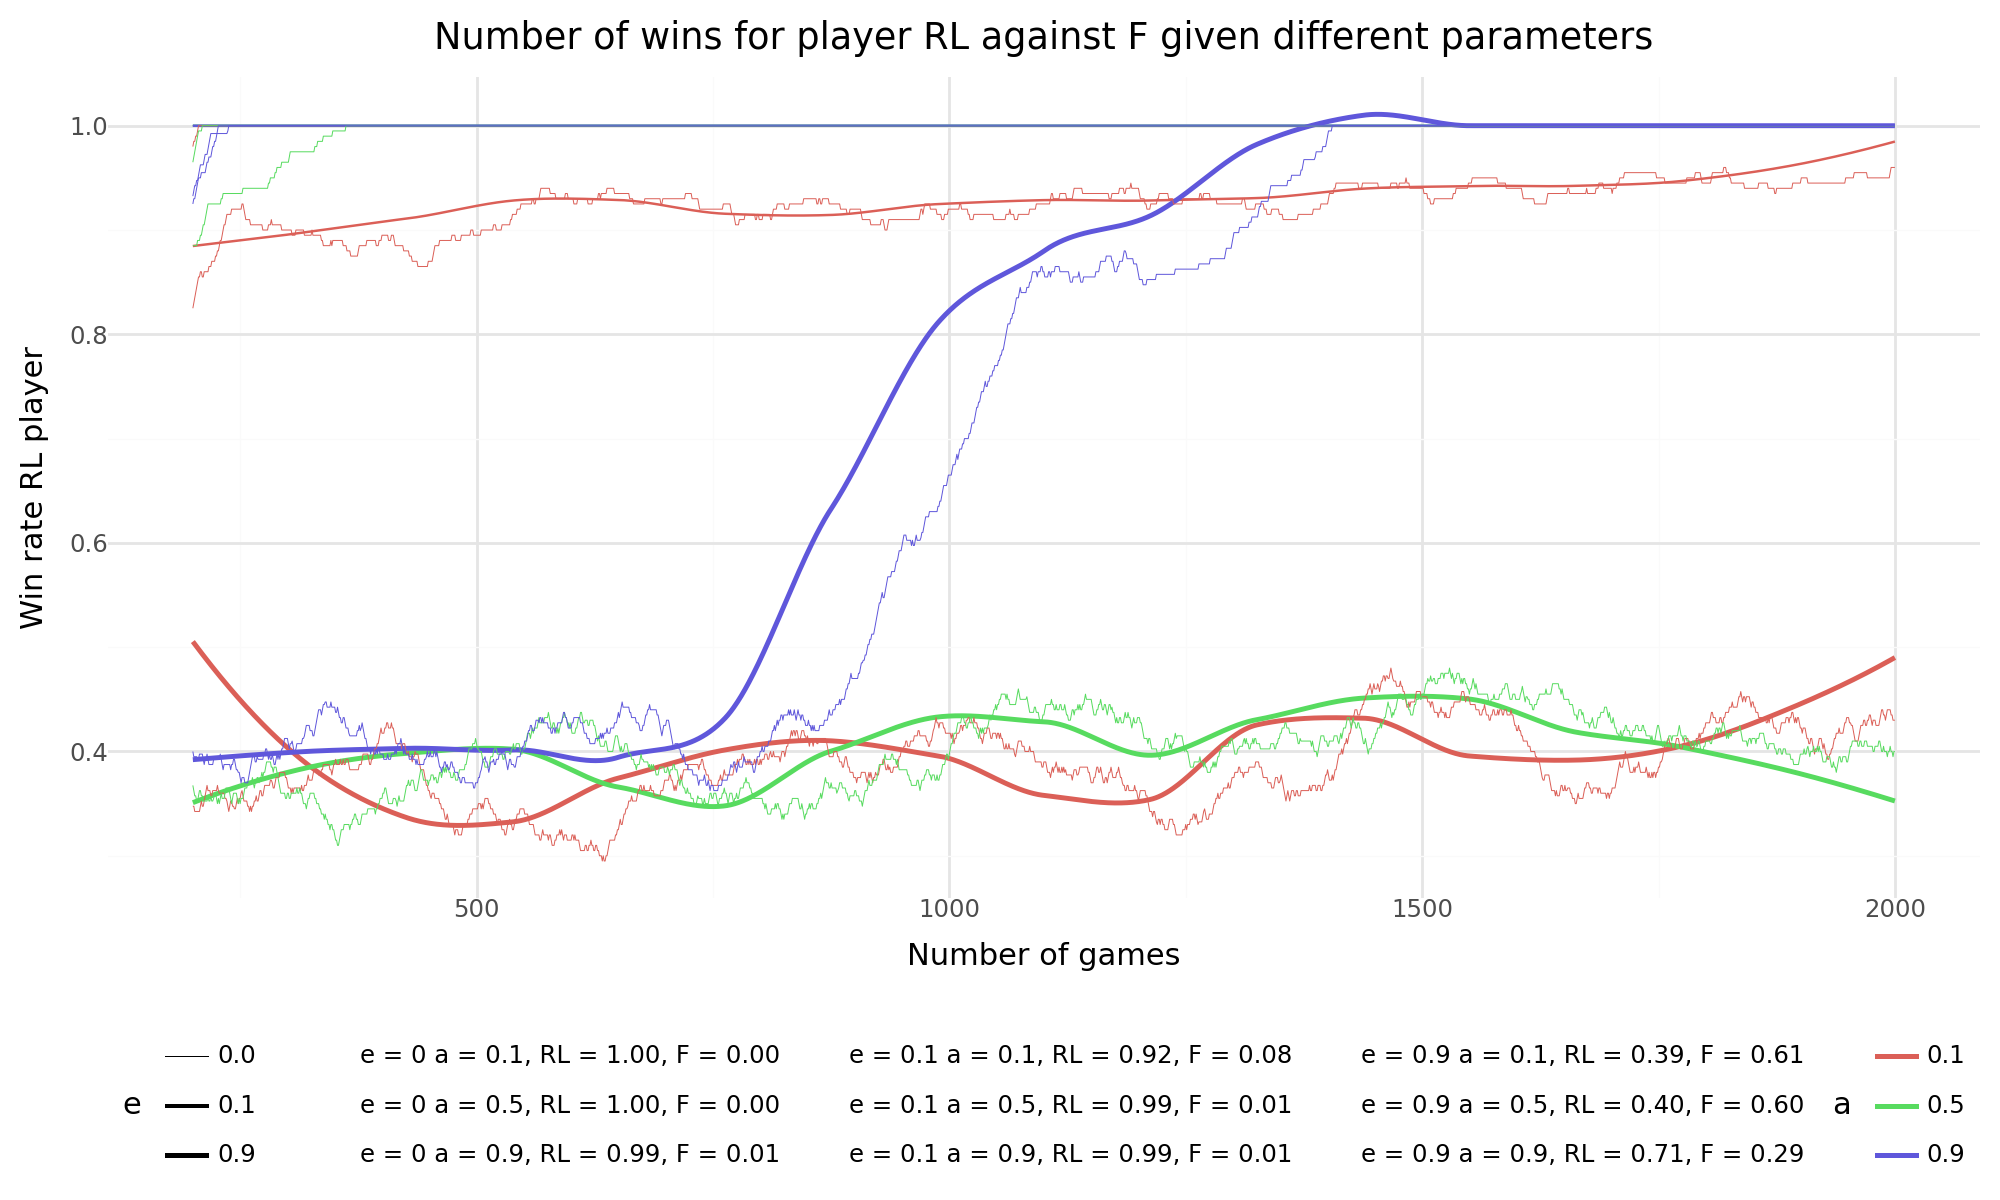

In [ ]:
#@title Effect of control parameters (against first index player)

random.seed(5782)  # set seed so get same results
game = EnvTicTacToe()
playerF = FirstIndexAgent(mark='F')
plot_param_effects(control_list, 2000, playerF, game)

Playing against a first index player give different results.

**Your turn**

  1. A high step size and a low exploration probability are good. Why?

    <details>
    <summary>Solution</summary>
    Since the other player is "predictable", a good strategy is trust in first learning experiences and and not the exploit to much. The RL player soon figures out how to win all the time.
    </details>

  2. Is the optimal policy for the RL player different here?

    <details>
    <summary>Solution</summary>
    Yes, optimal policies will be different based on our opponent.
    </details>

  3. Is the RL player learning to win?

    <details>
    <summary>Solution</summary>
    Mostly, but not necessarily if exploit to much.
    </details>

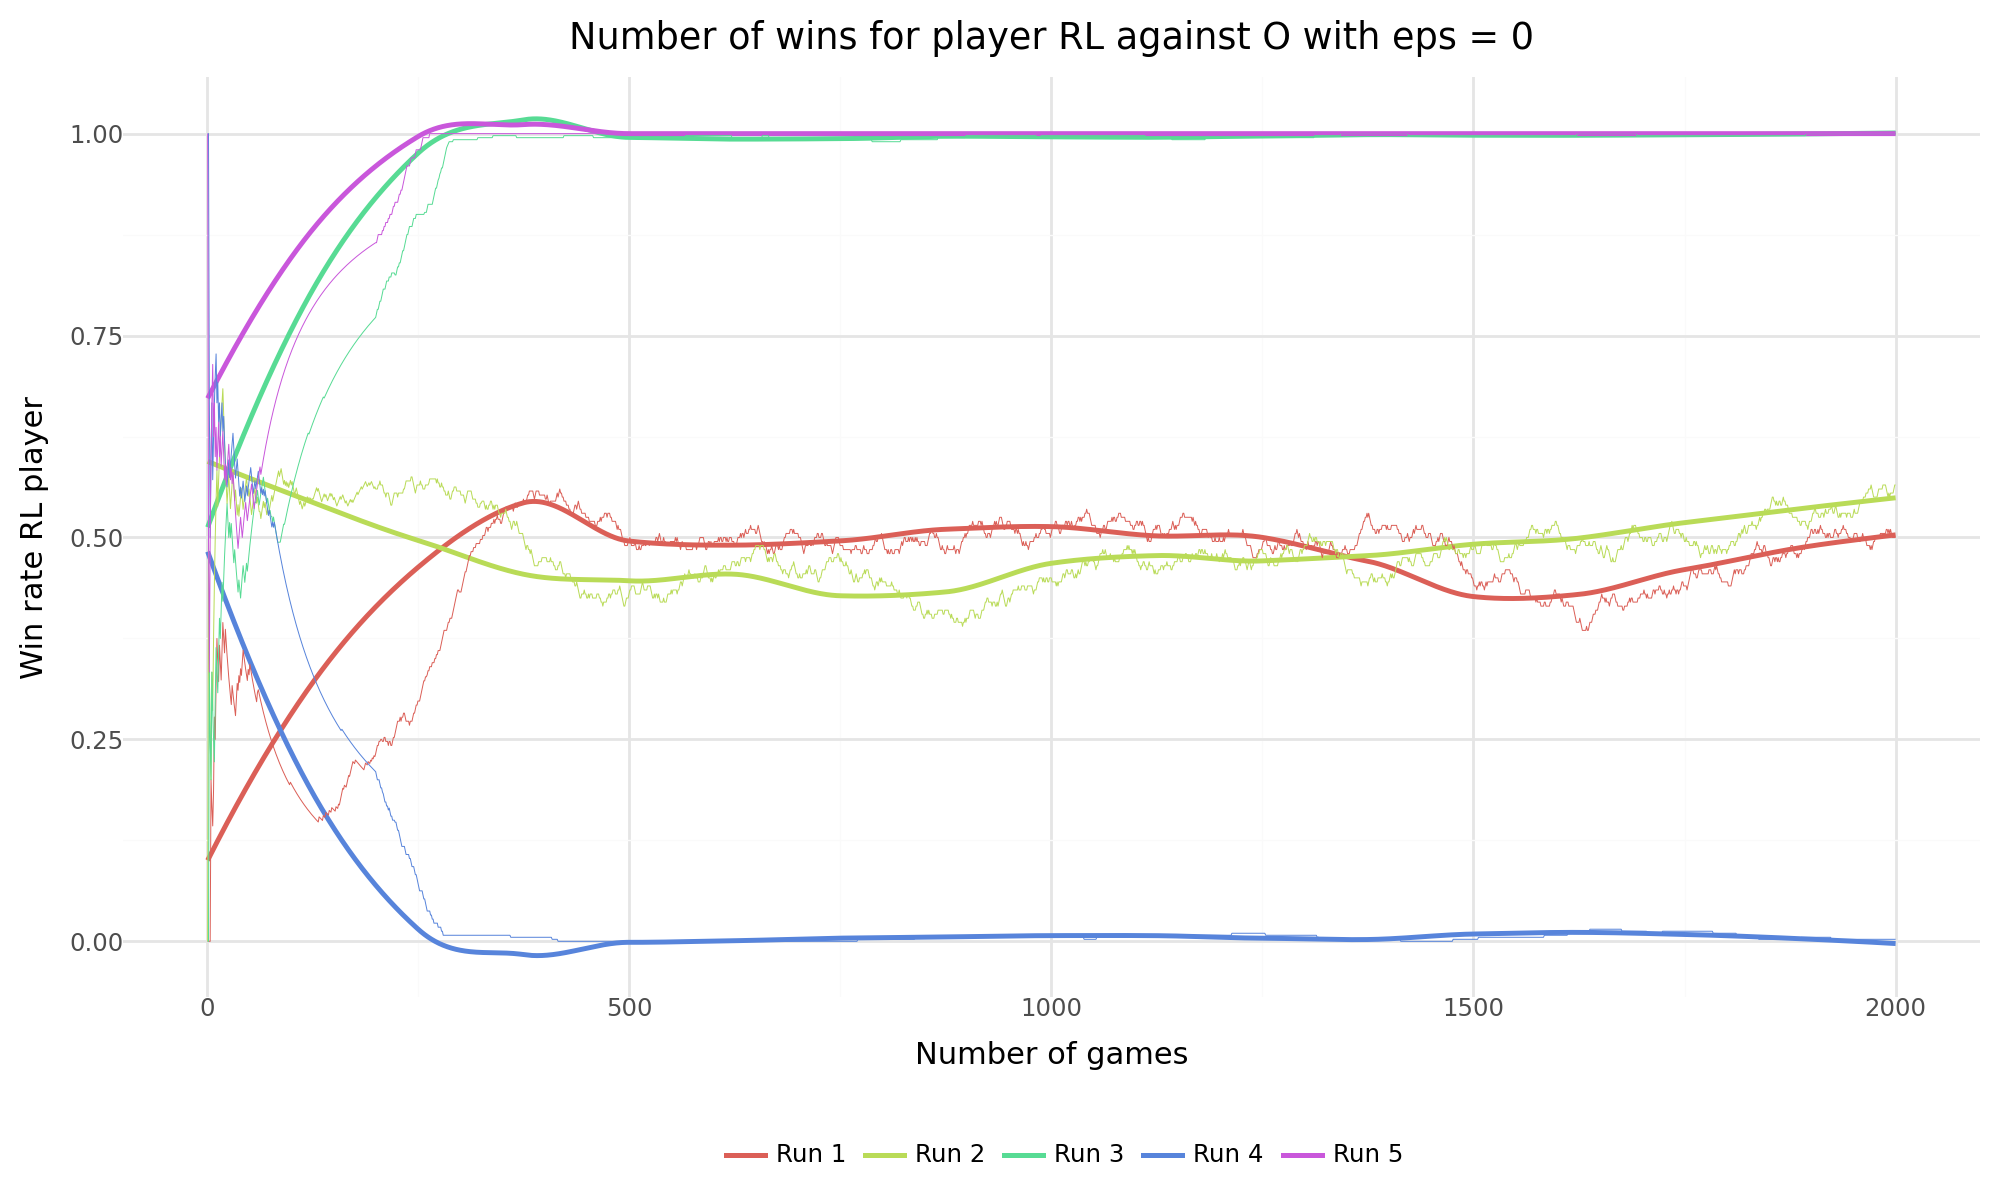

In [ ]:
#@title Effect no exploration (against RL player)

def plot_multiple_runs(runs):
  game = EnvTicTacToe()
  results = []

  for i in range(runs):
    playerRL = RLAgent(mark='RL', epsilon=0)
    playerO = RLAgent(mark='O', epsilon=0)
    res = play_games(2000, playerRL, playerO, game, keep_first_periods=True)
    df = res['dat']
    df['run'] = f"Run {i+1}"
    results.append(df)

  # Combine all data frames into one
  combined_df = pd.concat(results, ignore_index=True)
  combined_df = combined_df.dropna(subset=['winsA_r'])

  # Plot
  plot = (
      ggplot(combined_df, aes(x='game', y='winA', color='run')) +
      geom_smooth(aes(), method='loess', span=0.4, se=False) +
      geom_line(aes(y='winsA_r'), size=0.2) +
      labs(
          title=f"Number of wins for player RL against {playerO.mark} with eps = 0",
          y="Win rate RL player",
          x="Number of games",
          color=""
      ) +
      # guides(color=guide_legend(nrow=3), alpha=guide_legend(ncol=3, override_aes={'linetype': 'none'}), size=guide_legend(nrow=3)) +
      theme_minimal() +
      theme(legend_position='bottom', figure_size=(10, 6))#, legend_key_width = 30)
  )
  return plot


random.seed(867576)  # set seed so get same results
plot_multiple_runs(5)

In the above code, an RL player plays against another clever RL player O. If both players play using the same control parameters, one would expect that they, after learning, should win/lose with probability 0.5. However, if there is no exploration ($\epsilon = 0$), this is not always true. Depending on how the game starts, a player may learn a better strategy and win/lose more. That is, exploration is important!

Finally, let us play against a player O with fixed control parameters.

/usr/local/lib/python3.12/dist-packages/plotnine/scales/scale_alpha.py:71: PlotnineWarning: Using alpha for a discrete variable is not advised.


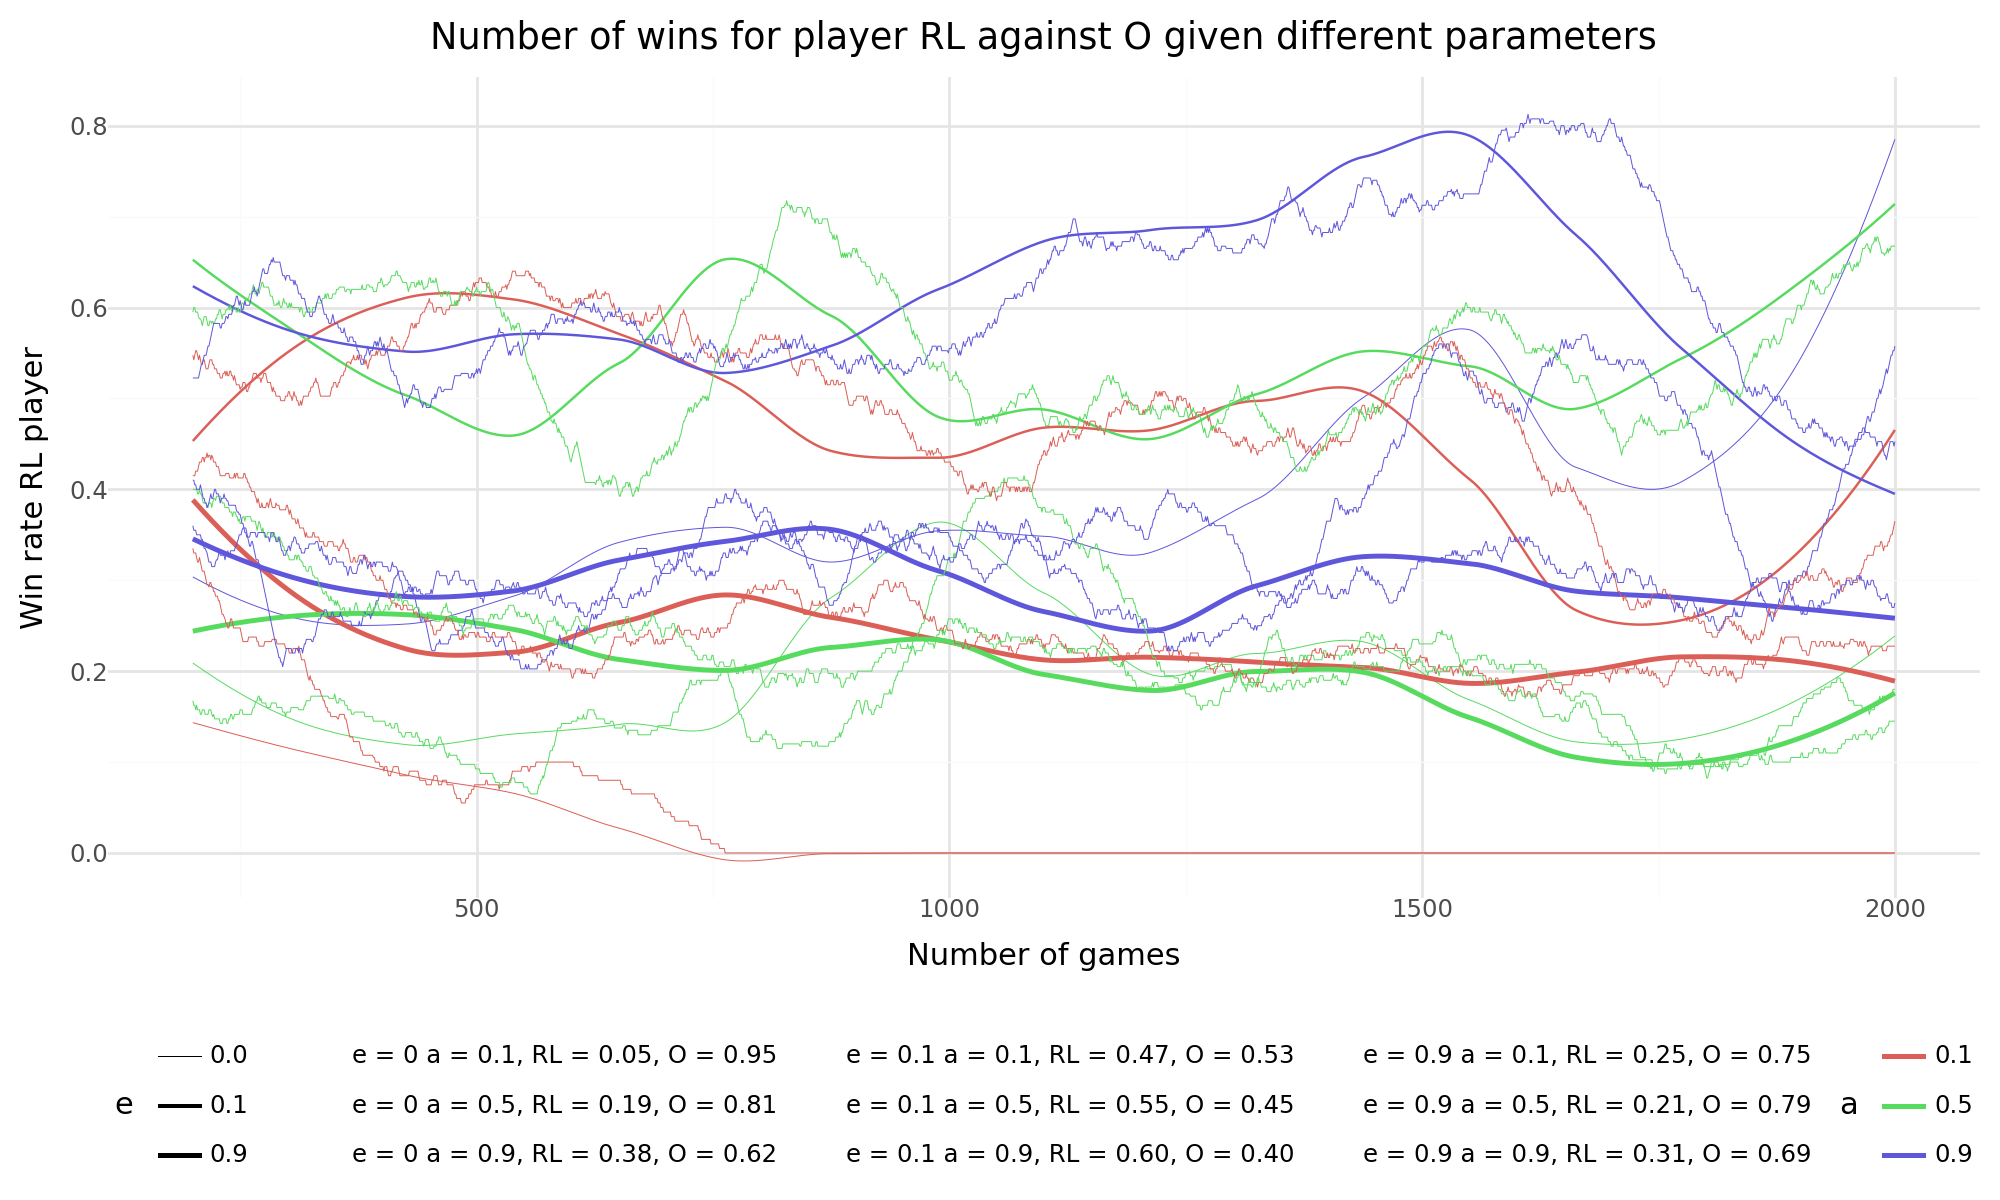

In [ ]:
#@title Effect of control parameters (against RL player with (e = 0.1, a = 0.5))

random.seed(57687682)  # set seed so get same results
game = EnvTicTacToe()
playerO = RLAgent(mark='O', epsilon=0.1, alpha=0.5)
plot_param_effects(control_list, 2000, playerO, game)

**Your turn**

  1. In general it is best to explore using the same probability otherwise you loose more. Why?

    <details>
    <summary>Solution</summary>
    If you exploit to little/much your opponent might suggest better actions than you.
    </details>


  2. A higher step size than your opponent seems best. Why?

    <details>
    <summary>Solution</summary>
    If you exploit at the same rate and you trust more in current values, you learn faster since the game is not too complicated.
    </details>

## Exercises






### Exercise - Self-Play

Consider Tic-Tac-Toe and assume that instead of an RL player against a random opponent, the reinforcement learning algorithm described above
played against itself. What do you think would happen in this case? Would it learn a different way of playing?

    <details>
    <summary>Solution</summary>
    If the exploration parameter is non-zero, the algorithm will continue to adapt until it reaches an equilibrium (either fixed or cyclical). You may try to code it.
    </details>



### Exercise - Symmetries

Many tic-tac-toe positions appear different but are really the same because of symmetries.

   1. How might we amend the reinforcement learning algorithm described above to take advantage of this?
   
    <details>
    <summary>Solution</summary>
    It is possible to use the four axes of symmetry to essentially fold the board down to a quarter of its size.
    </details>
   
   2. In what ways would this improve the algorithm?
   
    <details>
    <summary>Solution</summary>
    A smaller state space would increase the speed of learning and reduce the memory required.
    </details>
   
   3. Suppose the opponent did not take advantage of symmetries. In that case, should we? Is it true, then, that symmetrically equivalent positions should necessarily have the same value?
   
    <details>
    <summary>Solution</summary>
    If the opponent did not use symmetries then it could result in a worse learning. For example, if the opponent always played correct except for 1 corner, then using symmetries would mean you never take advantage of that information. That is, we should not use symmetries too since symmetrically equivalent positions do not always hold the same value in such a game.
    </details>




### Exercise - Greedy Play

Consider Tic-Tac-Toe and suppose the RL player is only greedy ($\epsilon = 0$), that is, always playing the move that that gives the highest probability of winning. Would it learn to play better, or worse, than a non-greedy player? What problems might occur?

    <details>
    <summary>Solution</summary>
    Using $\epsilon = 0$ may be okay for this game if the opponent uses a simple strategy (e.g. random or first index). However, in general the RL player would play worse. The chance the optimal action is the one with the current best estimate of winning is low and depending on the gameplay the RL player might win or loose. The RL player would also be unable to adapt to an opponent that slowly alter behavior over time. required.
    </details>



### Exercise - Learning from Exploration

Consider Tic-Tac-Toe and suppose the RL player is playing against an opponent with a fixed strategy. Suppose learning updates occur after all moves, including exploratory moves. If the step-size parameter is appropriately reduced over time (but not the tendency to explore), then the state values would converge to a set of probabilities.

   1. What are the two sets of probabilities computed when we do, and when we do not, learn from exploratory moves?
   
    <details>
    <summary>Solution</summary>
      The probability set $V(s)$ found by applying no learning from exploration is the probability of winning when using the optimal policy. The probability set $V(s)$ found by applying learning from exploration is the probability of winning, including the active exploration policy.
    </details>
      
   2. Assuming that we do continue to make exploratory moves, which set of probabilities might be better to learn? Which would result in more wins?

    <details>
    <summary>Solution</summary>
      The probability set found by applying no learning from exploration would result in more wins. The probability set found by applying learning from exploration is better to learn, as it reduces variance from sub-optimal future states.
    </details>

      
      


### Exercise - Other Improvements

Consider Tic-Tac-Toe. Can you think of other ways to improve the reinforcement learning player?

    <details>
    <summary>Solution</summary>
    Altering the exploration rate based on the variance in the opponent's actions. If the opponent is always making the same moves and you are winning from it, then using a non-zero exploration rate will make you lose your games. If the agent is able to learn how the opponent may react to certain moves, it will be easier for it to win, as it can influence the opponent to make moves that lead to a better state.
    </details>



In [ ]:
## Post step: Save notebook as HTML for print

def colab_html(file_name, notebookpath="/content/drive/MyDrive/Colab Notebooks/"):
    import os

    # Checking if file_name passed is a string.
    if not isinstance(file_name, str):
        raise TypeError(
            f"expected a string as file_name, but got {type(file_name)} instead."
        )

    # Using the defaults used by google.colab
    drive_mount_point = "/content/drive/"
    gdrive_home = os.path.join(drive_mount_point, "My Drive/")

    # If the drive is not already mounted, attempt to mount it.
    if not os.path.isdir(gdrive_home):
        from google.colab import drive
        drive.mount(drive_mount_point)

    # Check if the notebook exists in the Drive.
    if not os.path.isfile(os.path.join(notebookpath, file_name)):
        raise ValueError(f"file '{file_name}' not found in path '{notebookpath}'.")

    # # Installing all the recommended packages if print to pdf.
    # get_ipython().system(
    #     "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-latex-recommended >> /dev/null"
    # )

    # If file with the same name exists, remove it.
    out_file = os.path.join(notebookpath, file_name.split(".")[0] + ".html")

    if os.path.isfile(out_file):
        os.remove(out_file)
    if os.path.isfile(out_file):
        raise ValueError(f"File '{out_file}' not deleted.")

    # Attempt to convert to pdf and save it in Gdrive home dir using jupyter nbconvert command.
    try:
        cmd = f'jupyter nbconvert "{notebookpath}{file_name}" --to html --embed-images --template classic'
        get_ipython().system(
            cmd
        )
    except:
        return "nbconvert error"

    return "File saved to Drive."

colab_html('03_rl-in-action-solution.ipynb')

Mounted at /content/drive/
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/03_rl-in-action-solution.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 2303720 bytes to /content/drive/MyDrive/Colab Notebooks/03_rl-in-action-solution.html


'File saved to Drive.'